In [534]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from scipy import odr
import matplotlib.colors as mcolors
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS, CSS4_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [535]:
class Night:
    def __init__(self, file_path, night_number):
        self.path = file_path
        self.obs_night = night_number
        self.image_data = None
        self.headers = None
        self.wcs = None
        self.aligned = None
        self.template = None
        self.references = None
        self.obs_filter = None
        self.no_obs_images = None


    def initialize_frames(self):
        science_dir = sorted(glob.glob(self.path + '/*'))
        hdus = [fits.open(image) for image in science_dir]
        self.image_data = [image[1].data for image in hdus]
        self.headers = [image[1].header for image in hdus]
        self.wcs = WCS(self.headers[0])
        self.readout_noise = self.headers[0]['RDNOISE']

        try:
            self.aligned_images = [aa.register(image, self.image_data[0])[0] for image in self.image_data[0:]]
        except:
            self.aligned_images = self.image_data

        self.template = np.median(self.aligned_images, axis = 0)
        background = sep.Background(self.template)
        self.references = sep.extract(self.template - background.back(),  background.globalrms*3, minarea =25, segmentation_map=False)

        self.obs_filter = self.headers[0]['filter'][0]
        self.no_obs_images = len(self.aligned_images)



    def get_info(self):
        print(f"path: {self.path}, night {self.obs_night}, n_frames: {len(self.image_data)}, n_aligned: {len(self.aligned_images)}, wcs: {self.wcs}, n_ref: {len(self.references)}, filter: {self.obs_filter}")

In [536]:
class Source:
    def __init__(self, source, count, WCS):
        self.position = pixel_to_skycoord(source['x'], source['y'], wcs= WCS).transform_to('icrs')
        self.radius = (source['xmax'] - source['xmin'])/2
        self.source_id = count
        self.is_reference = None
        self.ref_mag = None
        self.ref_mag_err = None
        self.inst_mags = []
        self.inst_mag_errs = []
        self.calibrated_mags = []
        self.flagged = False

    def query_source(self):
        search = SDSS.query_crossid(self.position, fields = ['ra', 'dec', f'psfMag_{Nights[0].obs_filter}', f'psfMagErr_{Nights[0].obs_filter}'], radius = 15 * u.arcsec, region = False)
        if search:
            if search['type'] == "STAR":
                self.is_reference = True
                self.ref_mag = search[f'psfMag_{Nights[0].obs_filter}']
                self.ref_mag_err = search[f'psfMagErr_{Nights[0].obs_filter}']

    def boundary_check(self, night):
        source_xy = SkyCoord.to_pixel(self.position, wcs= night.wcs)
        if (night.headers[0]['NAXIS1'] - source_xy[0]) < 0 or source_xy[0] < 0 or (night.headers[0]['NAXIS2'] - source_xy[1]) < 0 or source_xy[1] < 0:
            self.flagged = True


    def aperture_photometry(self, img, nght):

        coords = SkyCoord.to_pixel(self.position, wcs = nght.wcs) #gets pixel values of source from RA DEC
        pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions

        radius_i = self.radius
        radius_o_0 = radius_i + 5 #inner annulus radius
        radius_o_1 = radius_o_0 + 5 #outer annulus radius

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(img) #gets data of source


        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
        background_mean = ApertureStats(img, background_annulus).mean


        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix) #total flux


        readout_sum_square = np.sum(source_circle*np.float64(nght.readout_noise**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

        delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(img, background_annulus)['aperture_sum'][0]))**(1/2)

        if source_flux_total < 0:
            print(self.source_id)
            self.flagged = True

        else:
            instrumental_mag = -2.5*np.log10(source_flux_total)
            instrumental_mag_error = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
            self.inst_mags.append(instrumental_mag)
            self.inst_mag_errs.append(instrumental_mag_error)

    def add_calibrated_mag(self, mag):
        self.calibrated_mags.append(mag)

    def get_info(self):
        print(f"ra_dec: {self.position}, rad: {self.radius}, ref_status: {self.is_reference}, ref_mag: {self.ref_mag}, inst_mag_avg:{np.mean(self.inst_mags)}, cal_mag_avg: {np.mean(self.calibrated_mags)}, flagged: {self.flagged}, ID: {self.source_id}")


In [537]:
#just want to initialize all the data here
def lin_model(p, x): #We need this for ODR later.
    return p[0] * x + p[1]

In [538]:
primary_dir = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*"))

Nights = [Night(directory, dir_number) for dir_number, directory in enumerate(primary_dir)]
for night in Nights:
    night.initialize_frames()

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [539]:
Sources = [Source(source, count, Nights[0].wcs) for count, source in enumerate(Nights[0].references)]
for source in Sources:
    if source.flagged == False:
        source.query_source()

In [540]:
night_array = []
mag_thresh = 15

for night in Nights:
    for image in night.aligned_images:
        for source in Sources:
            source.boundary_check(night)
            if source.flagged == False:
                source.aperture_photometry(image, night)
        night_array.append(night.obs_night)




In [541]:
slopes = []
zeros = []
for night in Nights:
    index_low = len(night.image_data)*night.obs_night
    index_high = len(night.image_data)*(1+night.obs_night)
    x = [np.mean(source.inst_mags[index_low:index_high]) for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    y = [source.ref_mag[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    #inst_mag_errs = [np.mean(source.inst_mag_errs[index_low:index_high]) for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    #sky_mag_errs = [source.ref_mag_err[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    #print(len(x),  len(y), len(inst_mag_errs), len(sky_mag_errs))
    #print(x, y, inst_mag_errs, sky_mag_errs)
    p = np.polyfit(x, y, deg = 1)

    #linear = odr.Model(lin_model)
    #calibration_data = odr.Data(x, y, we=inst_mag_errs, wd = sky_mag_errs)
    #fit_params = odr.ODR(calibration_data, linear, beta0=[1.0, 23.5]).run() #beta0 is initial guesses
    #print(fit_params.beta[0], fit_params.beta[1])
    #slopes.append(fit_params.beta[0])
    #zeros.append(fit_params.beta[1])
    slopes.append(p[0])
    slopes.append(p[1])


0.9095040400598465 23.42061669193011
0.9045462296016892 23.175049425367234
0.886548875897924 22.865505488726303
0.8627856189827323 22.649045506200665
0.8746376918510195 22.77911098325215
0.8771854843328754 22.773630575946083
0.8475063550141273 22.442846175943018
0.9142965748594618 23.50010037829015
0.8628137729284677 22.639999449583527
0.8442304256921466 22.636972308824042


In [542]:
slopes_scaled = np.array(slopes)[np.array(night_array)]
zeros_scaled = np.array(zeros)[np.array(night_array)]
for source in Sources:
    if source.flagged != True:
        for i in range(0, len(slopes_scaled)):
            #print(i, slopes_scaled[i], zeros_scaled[i])
            mag = (source.inst_mags[i]*slopes_scaled[i] + zeros_scaled[i])
            source.add_calibrated_mag(mag)

print(slopes[7], zeros[7])




0.9142965748594618 23.50010037829015


In [543]:
print(Sources[23].inst_mags[179], Sources[23].calibrated_mags[179])

-10.72894289537694 13.690664637184256


250


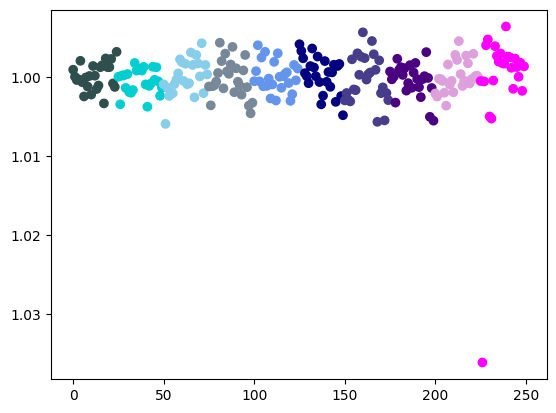

In [544]:

color_arr = np.array(sorted(CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))))
l = np.arange(0, len(slopes_scaled))

median_curves = []
for night in Nights:
    median_mags = []
    index_l = len(night.image_data)*night.obs_night
    index_h = len(night.image_data)*(1+night.obs_night)
    for source in Sources:
        if source.flagged != True:
            median_mags.append(source.calibrated_mags[index_l:index_h])
    median_curve = np.median(median_mags, axis = 0)/np.median(median_mags)
    median_curves.append(median_curve)
curve = np.concatenate(median_curves)
med_curve = np.concatenate(curve)
print(len(med_curve))
plt.scatter(l, med_curve, c = color_arr[93::5][np.array(night_array)])
plt.gca().invert_yaxis()
plt.show()




ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.633724032747088, cal_mag_avg: 15.301093675504646, flagged: False, ID: 0
None


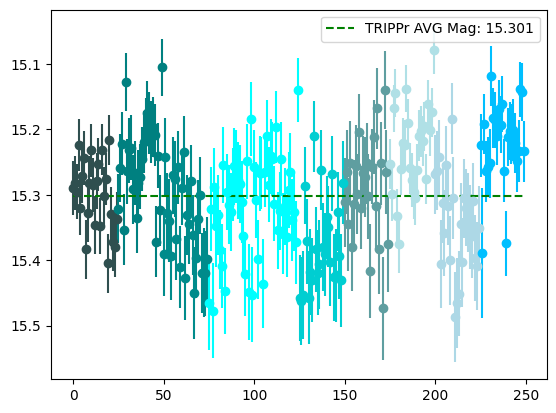

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.77550571, 54.14508597)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.709618408584095, cal_mag_avg: 16.111343111649482, flagged: False, ID: 1
None


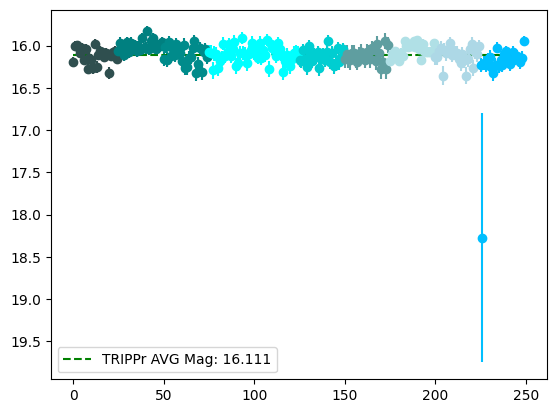

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79248564, 54.39747745)>, rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.706171995415074, cal_mag_avg: 15.237726154964907, flagged: False, ID: 2
None


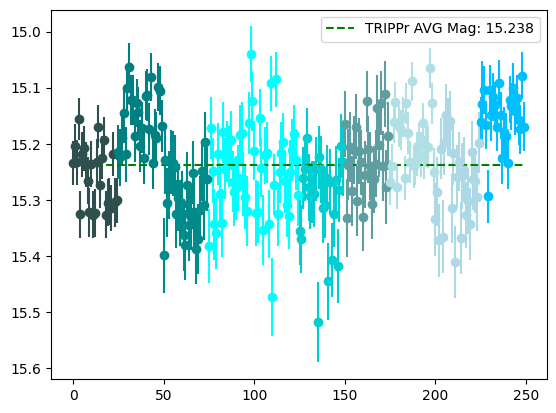

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80186801, 54.29859178)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.037096617133915, cal_mag_avg: 16.702632335814485, flagged: False, ID: 3
None


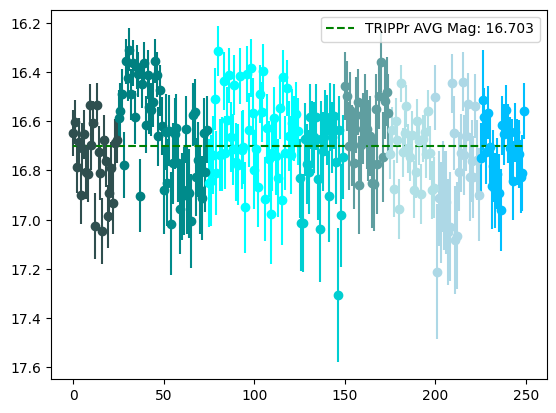

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79447654, 54.0838712)>, rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.381221642377652, cal_mag_avg: 14.645201040169141, flagged: False, ID: 4
None


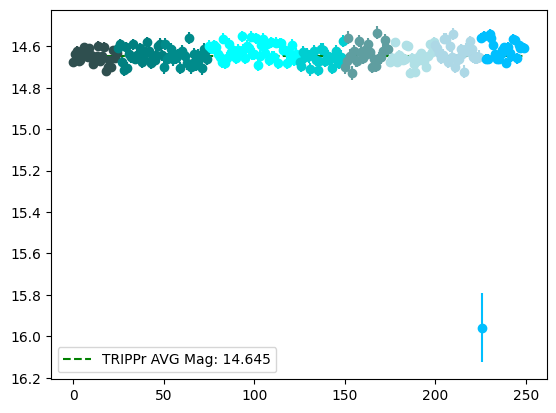

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80206959, 54.34873014)>, rad: 27.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.545492898210782, cal_mag_avg: 12.743303739828526, flagged: False, ID: 5
None


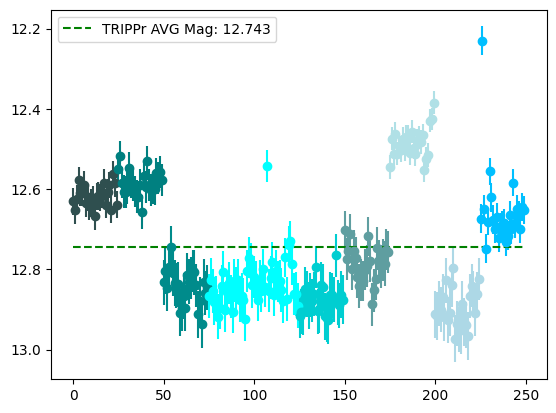

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80676757, 54.26196473)>, rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.517934875271433, cal_mag_avg: 13.647559672258318, flagged: False, ID: 6
None


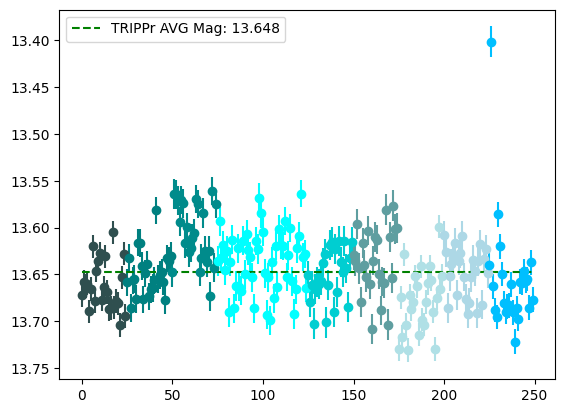

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.81073532, 54.37035913)>, rad: 9.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.336742303561788, cal_mag_avg: 12.928760544301388, flagged: False, ID: 7
None


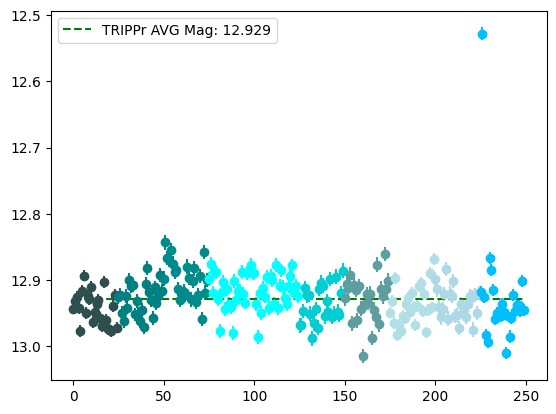

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8152421, 54.45781723)>, rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.327955877865474, cal_mag_avg: 14.691772510282846, flagged: False, ID: 8
None


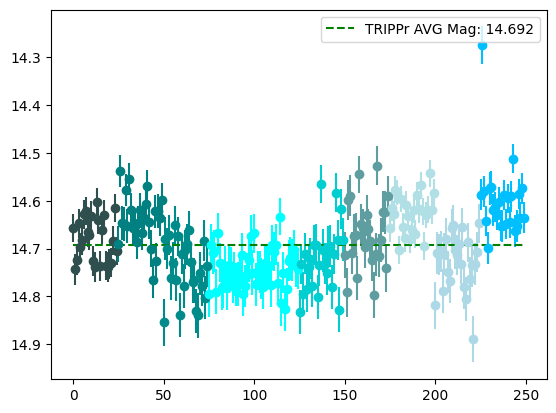

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80834476, 54.11467639)>, rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.292135626926967, cal_mag_avg: 16.477532352868987, flagged: False, ID: 9
None


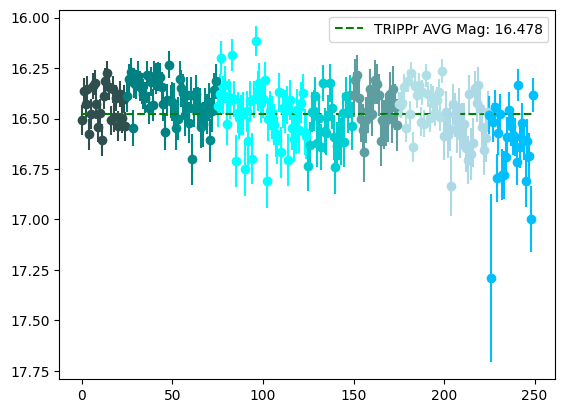

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.81572421, 54.26237173)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.577831119430728, cal_mag_avg: 16.226893129486932, flagged: False, ID: 10
None


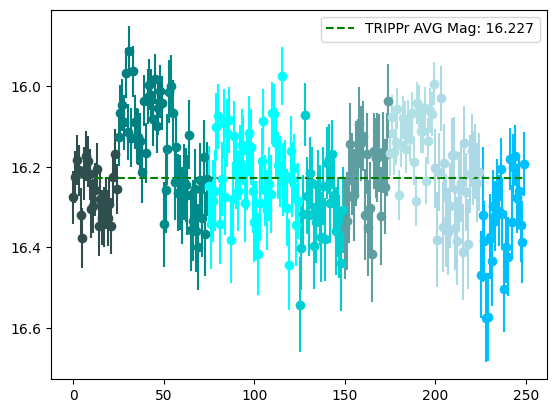

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.82637993, 54.34790299)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.364627315754518, cal_mag_avg: 15.537161285394554, flagged: False, ID: 11
None


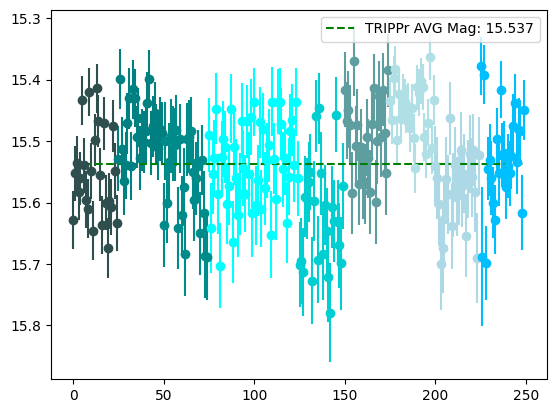

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.84294319, 54.26012276)>, rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.72514344994934, cal_mag_avg: 14.343375023744825, flagged: False, ID: 12
None


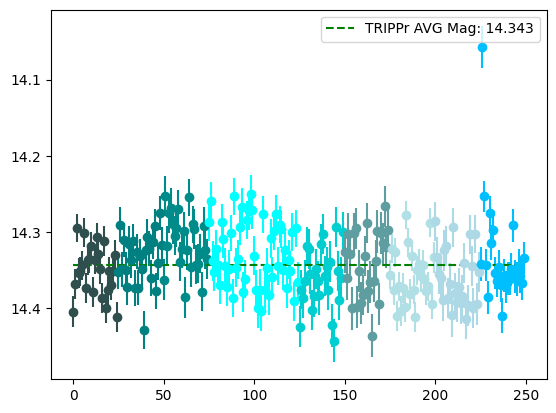

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.83908433, 54.0373817)>, rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
14.14103, inst_mag_avg:-10.095431400162214, cal_mag_avg: 14.018291445428941, flagged: False, ID: 13
None
      psfMag_r     
-------------------
0.12273855457105931


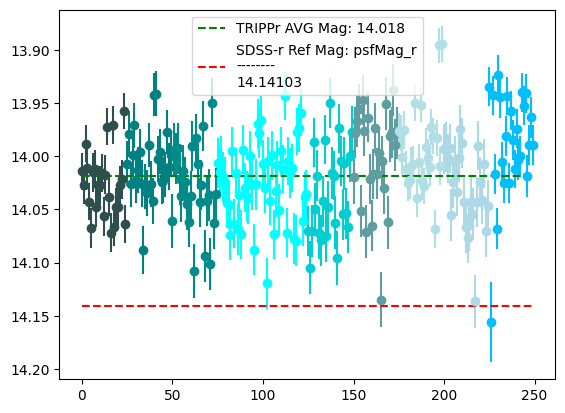

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8491348, 54.27057194)>, rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.565888491579053, cal_mag_avg: 16.23786045397402, flagged: False, ID: 14
None


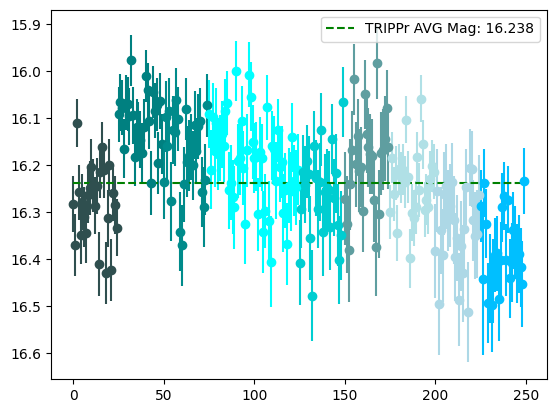

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.84889875, 54.24229868)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.616128746405007, cal_mag_avg: 15.316652636835489, flagged: False, ID: 15
None


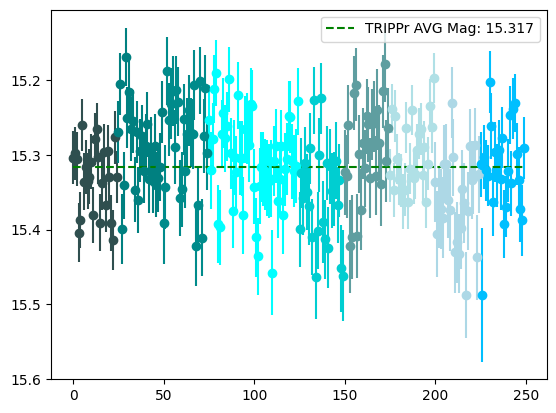

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85672758, 54.37867585)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.239334424645538, cal_mag_avg: 15.64724954482429, flagged: False, ID: 16
None


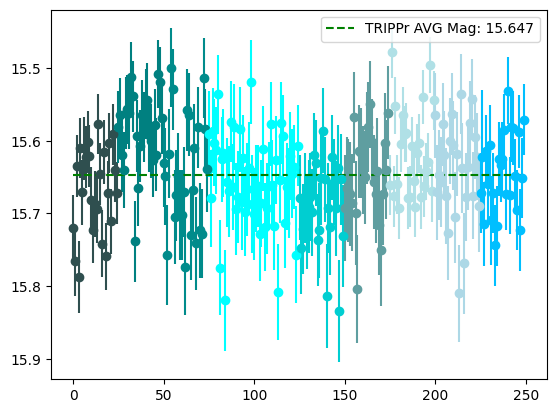

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85366314, 54.23249378)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.8611978021673705, cal_mag_avg: 15.978508852728371, flagged: False, ID: 17
None


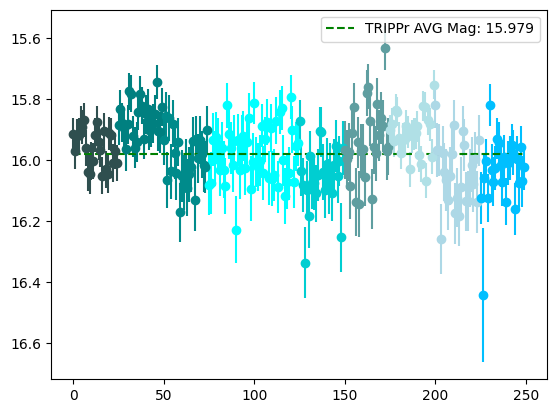

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85030384, 54.12207102)>, rad: 2.5, ref_status: True, ref_mag: psfMag_r
--------
16.39703, inst_mag_avg:-7.36550998285941, cal_mag_avg: 16.413575332200978, flagged: False, ID: 18
None
      psfMag_r      
--------------------
-0.01654533220097676


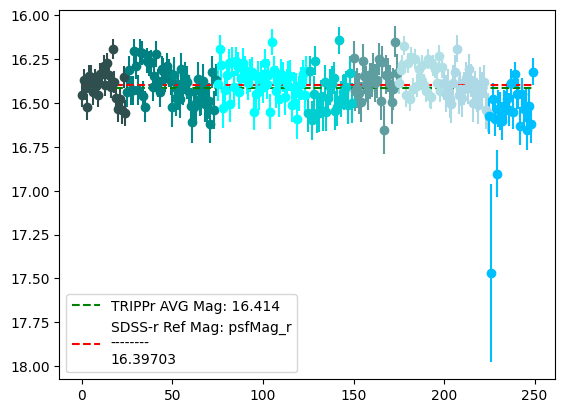

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85063554, 54.04551099)>, rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
17.44732, inst_mag_avg:-7.496533687389651, cal_mag_avg: 16.29862064600739, flagged: False, ID: 19
None
     psfMag_r     
------------------
1.1486993539926118


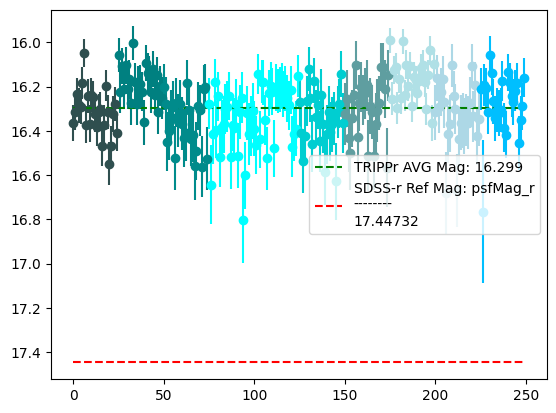

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86518663, 54.31283836)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.518526139860088, cal_mag_avg: 16.279198229024836, flagged: False, ID: 20
None


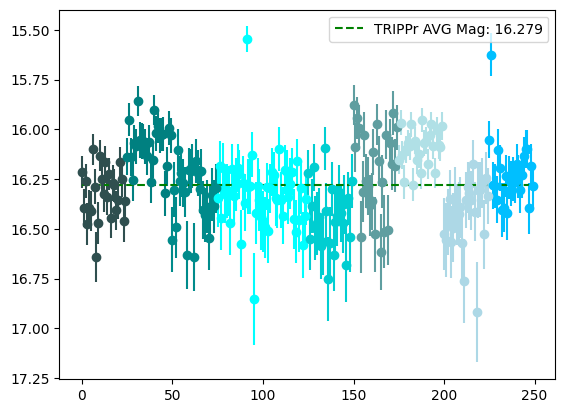

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86800042, 54.35876675)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.078559523919353, cal_mag_avg: 16.665660320128293, flagged: False, ID: 21
None


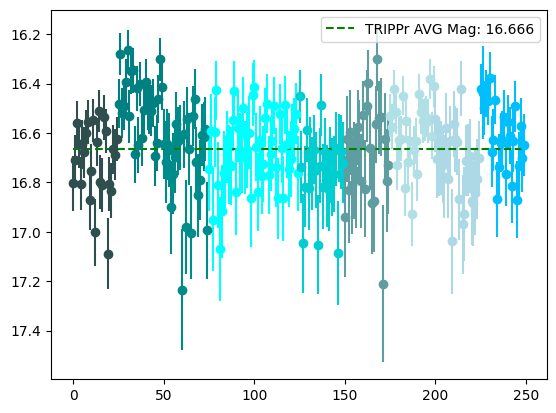

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86386421, 54.06701257)>, rad: 6.0, ref_status: True, ref_mag: psfMag_r
--------
14.09081, inst_mag_avg:-9.953306030385596, cal_mag_avg: 14.143023130123082, flagged: False, ID: 22
None
      psfMag_r      
--------------------
-0.05221313012308215


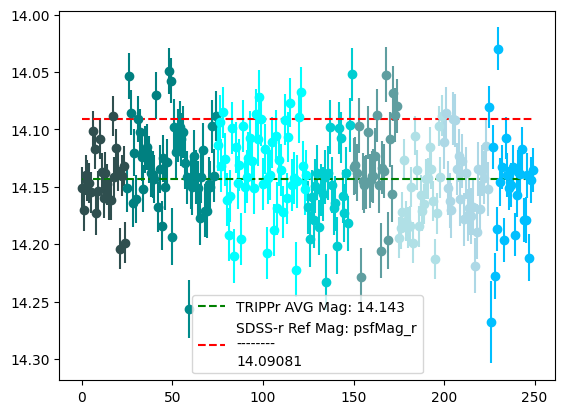

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8615306, 54.00013879)>, rad: 6.5, ref_status: True, ref_mag: psfMag_r
--------
13.74609, inst_mag_avg:-10.455777242266109, cal_mag_avg: 13.702072191368732, flagged: False, ID: 23
None
      psfMag_r     
-------------------
0.04401780863126881


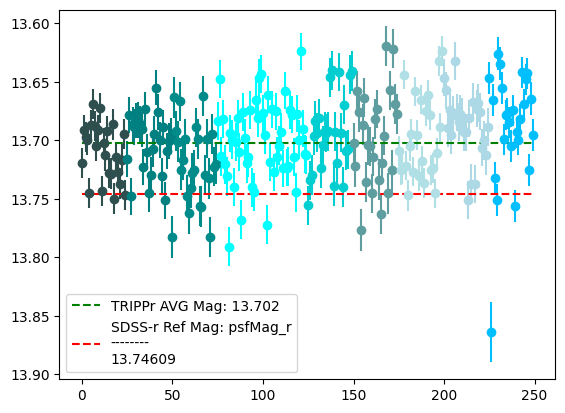

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.87048358, 54.19250825)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.020200931418598, cal_mag_avg: 15.839356971476642, flagged: False, ID: 24
None


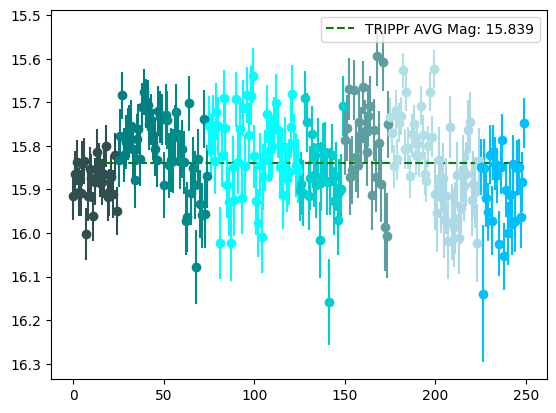

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8805303, 54.35398963)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.935448162793546, cal_mag_avg: 15.913510323192252, flagged: False, ID: 25
None


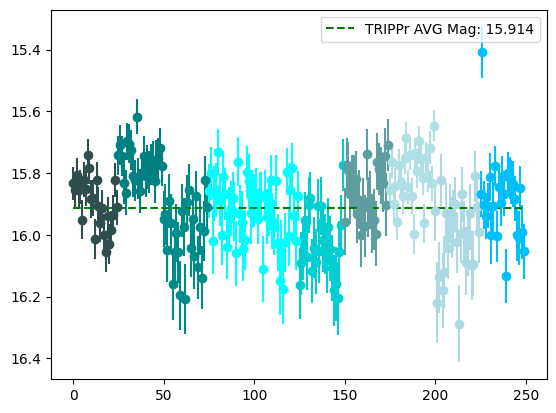

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.87569614, 54.06163606)>, rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
14.91957, inst_mag_avg:-9.035080066259106, cal_mag_avg: 14.948943204062477, flagged: False, ID: 26
None
       psfMag_r      
---------------------
-0.029373204062476788


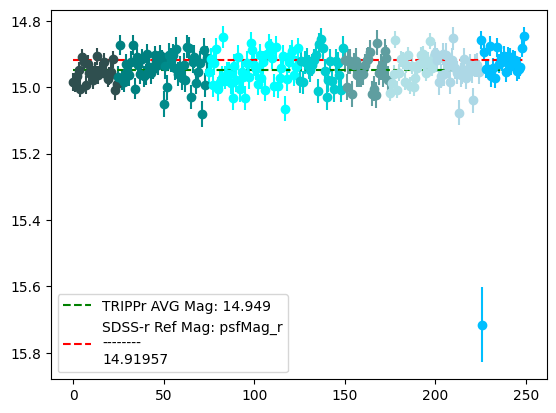

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88734587, 54.38781215)>, rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.484204380509313, cal_mag_avg: 14.555012467862248, flagged: False, ID: 27
None


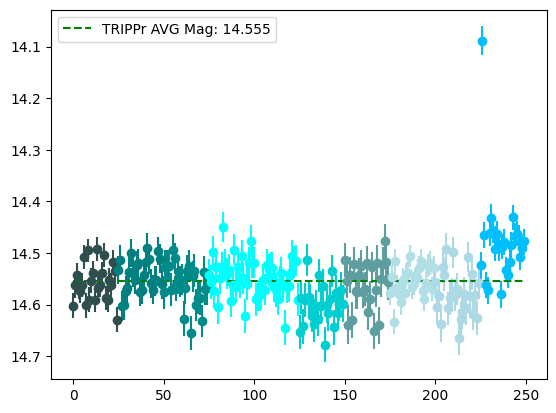

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88665759, 54.33614578)>, rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.873778941391389, cal_mag_avg: 16.84488568832857, flagged: False, ID: 28
None


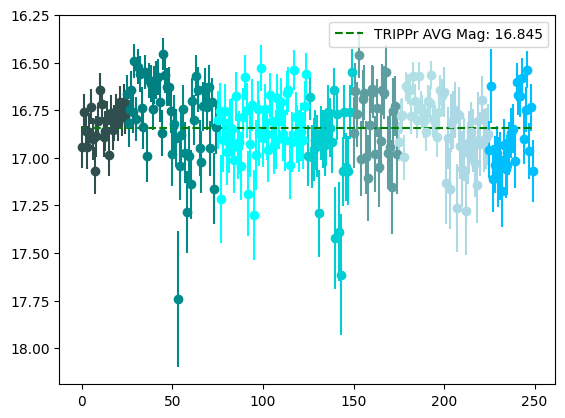

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88500977, 54.28890995)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.1684361251302, cal_mag_avg: 16.585864905346288, flagged: False, ID: 29
None


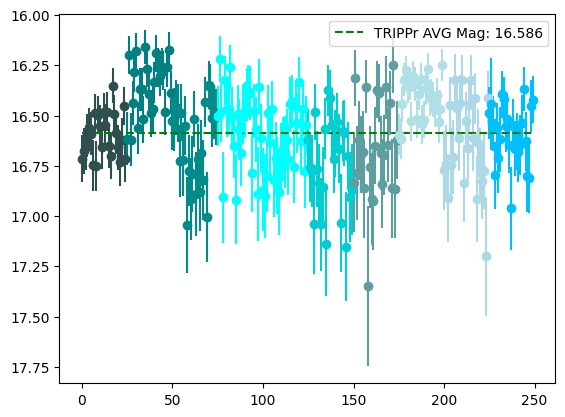

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88362985, 54.1138174)>, rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
15.02432, inst_mag_avg:-8.906093420113319, cal_mag_avg: 15.06206729450625, flagged: False, ID: 30
None
      psfMag_r      
--------------------
-0.03774729450625003


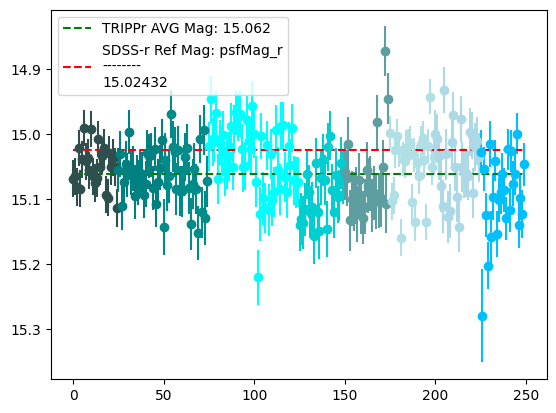

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.89603392, 54.43759338)>, rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.35707567080756, cal_mag_avg: 14.666471337359754, flagged: False, ID: 31
None


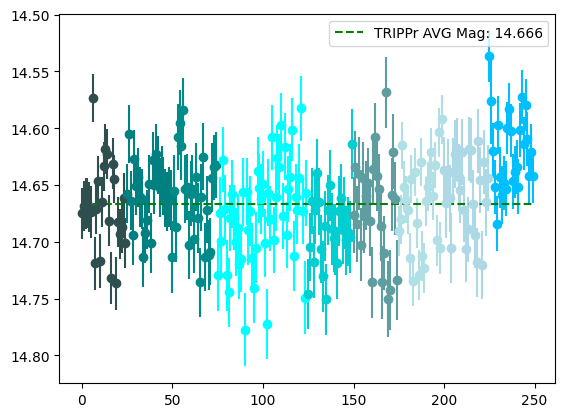

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.89840483, 54.3416589)>, rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.911796950870308, cal_mag_avg: 15.056978022703857, flagged: False, ID: 32
None


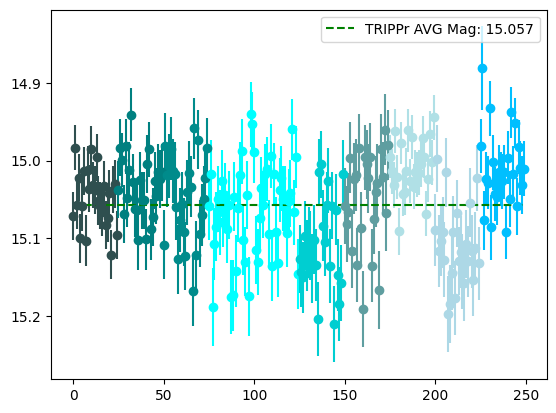

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.90052695, 54.34964825)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.025404409491573, cal_mag_avg: 15.834879728878967, flagged: False, ID: 33
None


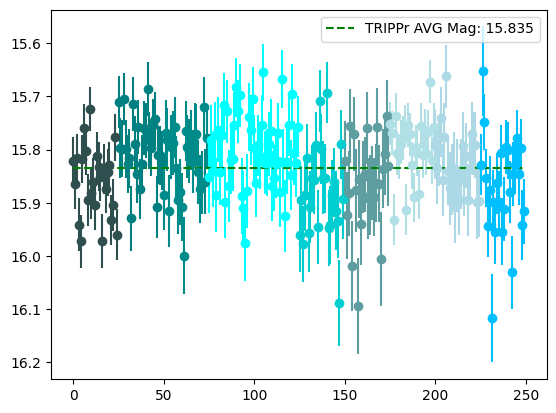

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91055426, 54.31169678)>, rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-12.610404210926587, cal_mag_avg: 11.806725693402703, flagged: False, ID: 34
None


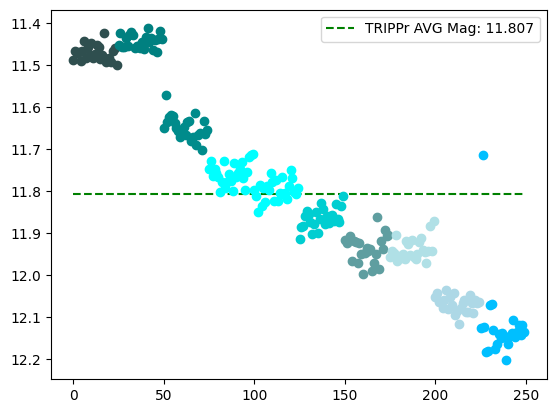

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91689781, 54.39173506)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.494383469764388, cal_mag_avg: 15.423425083682993, flagged: False, ID: 35
None


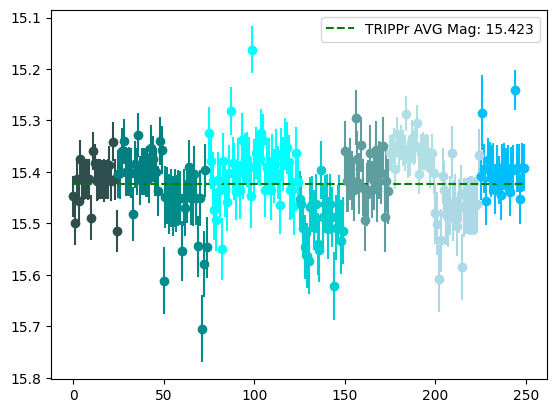

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91605555, 54.31568738)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.233933582409042, cal_mag_avg: 16.527924191588042, flagged: False, ID: 36
None


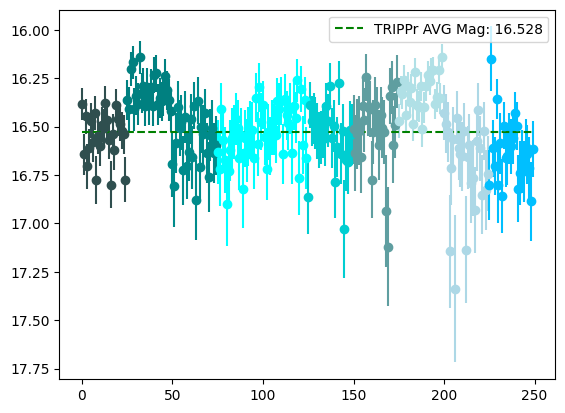

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.92241703, 54.31797144)>, rad: 10.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.772876331587558, cal_mag_avg: 14.300790819488673, flagged: False, ID: 37
None


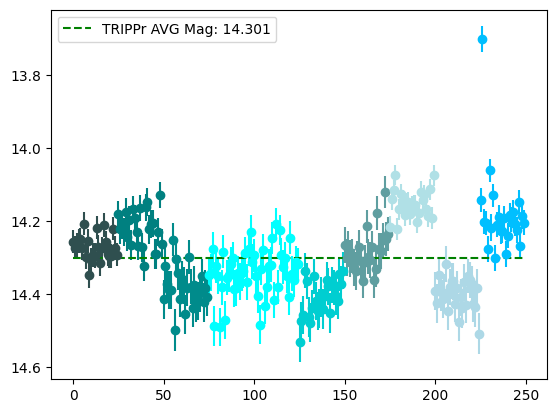

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.9417537, 54.44672344)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.413657501261136, cal_mag_avg: 15.494516351556253, flagged: False, ID: 38
None


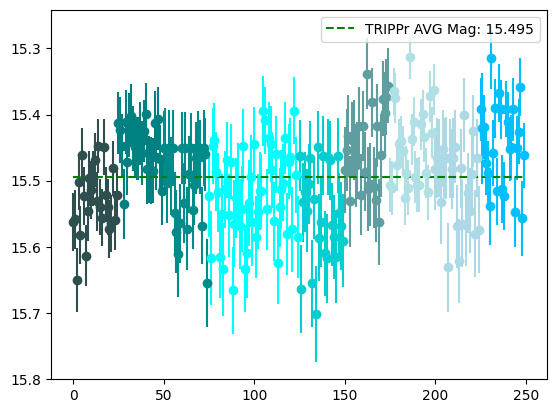

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.93805894, 54.27106037)>, rad: 6.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.221635134081316, cal_mag_avg: 13.907548973237395, flagged: False, ID: 39
None


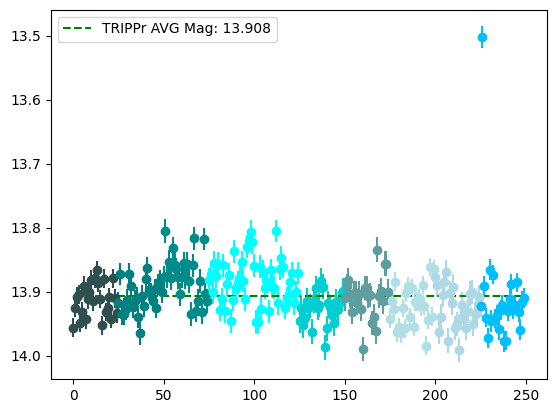

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.94550841, 54.29515842)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.029500401978181, cal_mag_avg: 15.830907389406246, flagged: False, ID: 40
None


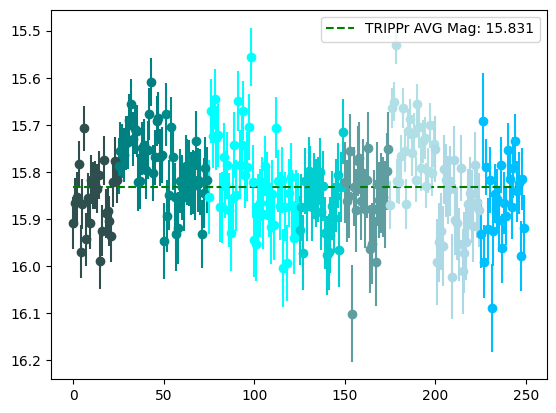

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95617089, 54.46091011)>, rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.40927, inst_mag_avg:-7.550046192964401, cal_mag_avg: 16.252582525580497, flagged: False, ID: 41
None
     psfMag_r     
------------------
0.1566874744195026


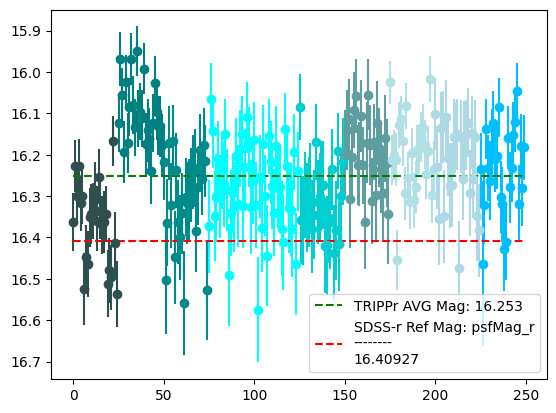

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95549419, 54.41993155)>, rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.123423791020216, cal_mag_avg: 16.625858757716436, flagged: False, ID: 42
None


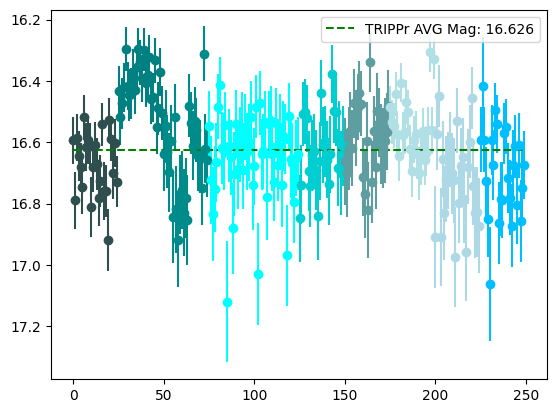

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95776278, 54.15153029)>, rad: 11.5, ref_status: True, ref_mag: psfMag_r
--------
11.62752, inst_mag_avg:-12.53989664330882, cal_mag_avg: 11.872052471645583, flagged: False, ID: 43
None
      psfMag_r      
--------------------
-0.24453247164558256


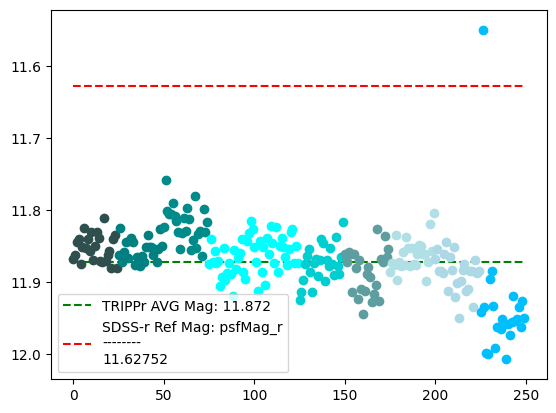

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.97193498, 54.36827617)>, rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.212689301700054, cal_mag_avg: 16.547512359471998, flagged: False, ID: 44
None


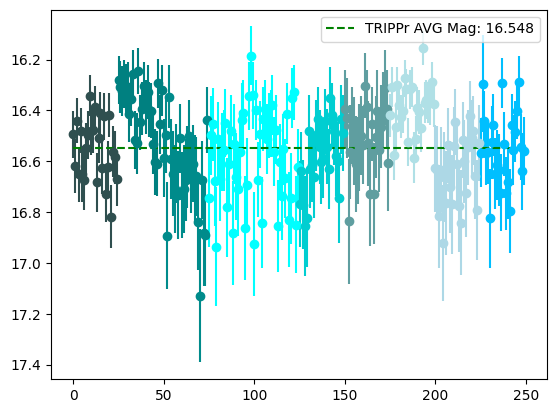

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.97523909, 54.36934526)>, rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.88660320579475, cal_mag_avg: 15.955928581131477, flagged: False, ID: 45
None


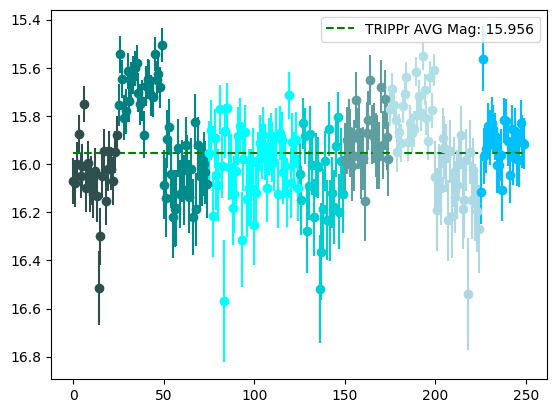

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.98336712, 54.34931789)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.807115536518495, cal_mag_avg: 16.026144996700406, flagged: False, ID: 46
None


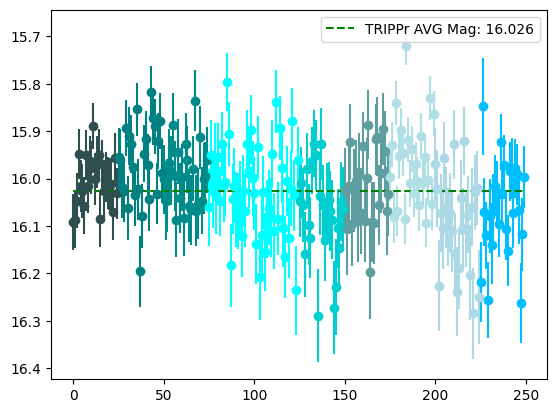

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01134848, 54.30502921)>, rad: 7.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.729697898726789, cal_mag_avg: 13.461512100244352, flagged: False, ID: 47
None


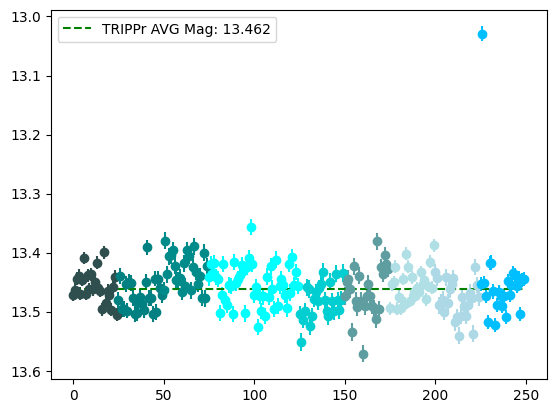

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01156344, 54.16910002)>, rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
15.32855, inst_mag_avg:-8.605734421409673, cal_mag_avg: 15.325496461627901, flagged: False, ID: 48
None
      psfMag_r     
-------------------
0.00305353837209843


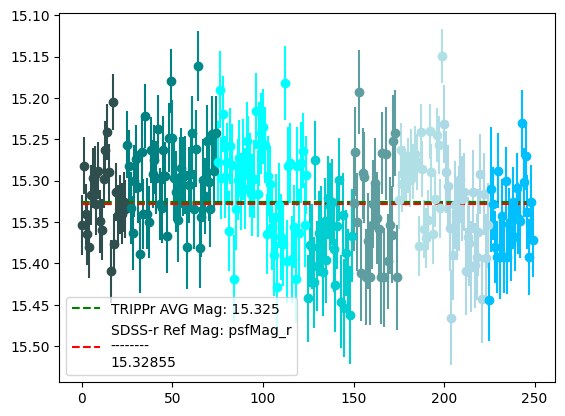

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.00453763, 53.98887093)>, rad: 5.5, ref_status: True, ref_mag: psfMag_r
--------
  14.504, inst_mag_avg:-10.39093961224678, cal_mag_avg: 13.758783315596508, flagged: False, ID: 49
None
     psfMag_r     
------------------
0.7452166844034913


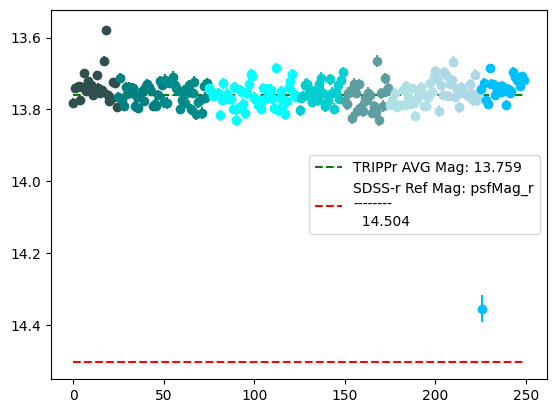

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01841136, 54.22552572)>, rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.015388058040644, cal_mag_avg: 13.210656434148998, flagged: False, ID: 50
None


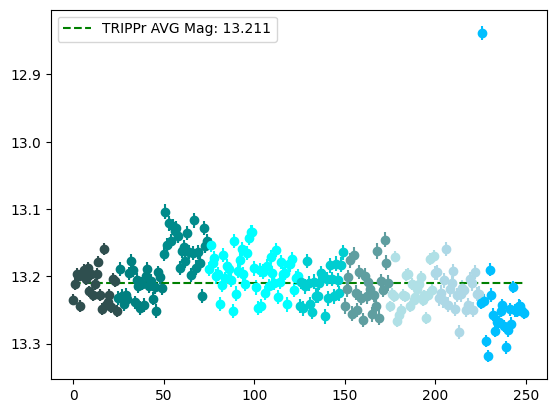

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.03006488, 54.35204566)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.482539321433126, cal_mag_avg: 15.433530675184404, flagged: False, ID: 51
None


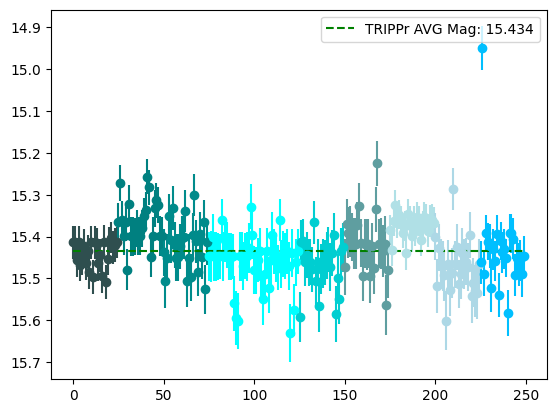

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.04682416, 54.42158107)>, rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.685433385772711, cal_mag_avg: 16.13263172749177, flagged: False, ID: 52
None


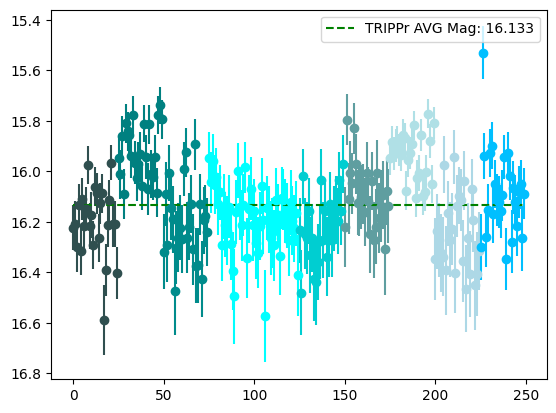

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.03188549, 54.00407838)>, rad: 4.5, ref_status: True, ref_mag: psfMag_r
--------
14.47984, inst_mag_avg:-9.49276085240828, cal_mag_avg: 14.54714517159692, flagged: False, ID: 53
None
      psfMag_r      
--------------------
-0.06730517159692084


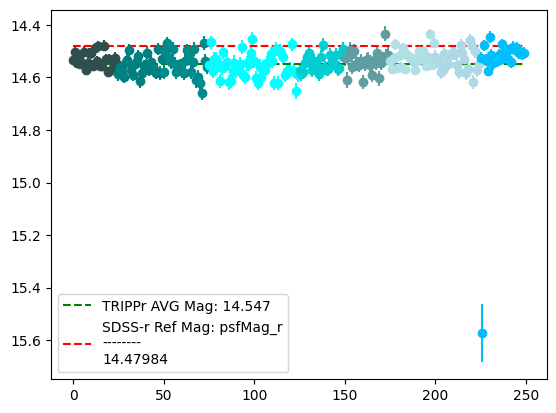

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.05144253, 54.23152052)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.399386292393437, cal_mag_avg: 16.383039908308703, flagged: False, ID: 54
None


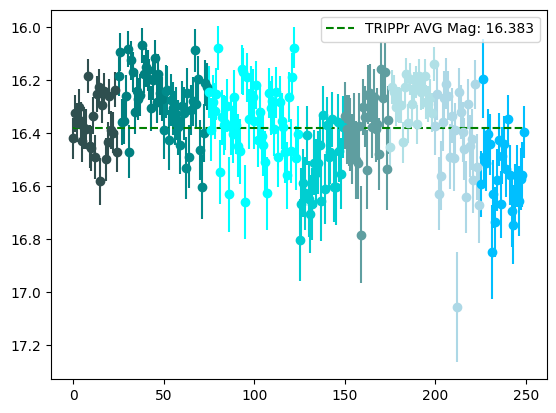

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.04809302, 53.9938326)>, rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
15.95399, inst_mag_avg:-7.894191001087391, cal_mag_avg: 15.949541301220306, flagged: False, ID: 55
None
      psfMag_r      
--------------------
0.004448698779693672


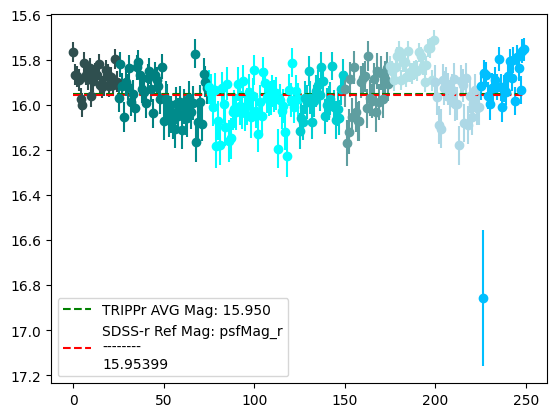

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.0674882, 54.42881879)>, rad: 5.5, ref_status: True, ref_mag: psfMag_r
--------
 23.4499, inst_mag_avg:-9.983256742735934, cal_mag_avg: 14.116809182633187, flagged: False, ID: 56
None
     psfMag_r    
-----------------
9.333090817366813


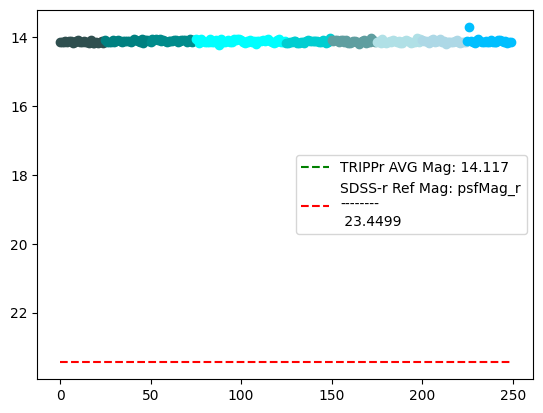

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.06828153, 54.39069706)>, rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.142940530839633, cal_mag_avg: 15.731796257382124, flagged: False, ID: 57
None


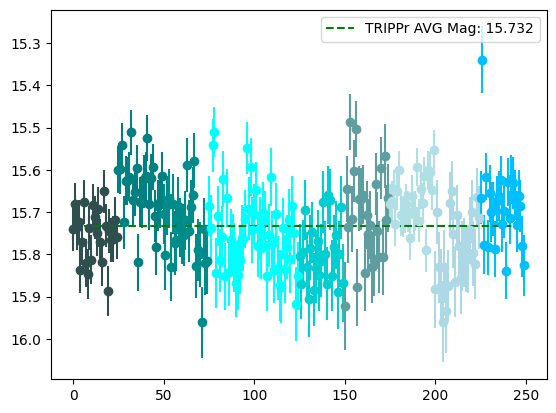

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.06442548, 54.00816578)>, rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
 13.2153, inst_mag_avg:-10.889995102841176, cal_mag_avg: 13.320763052037277, flagged: False, ID: 58
None
      psfMag_r     
-------------------
-0.1054630520372779


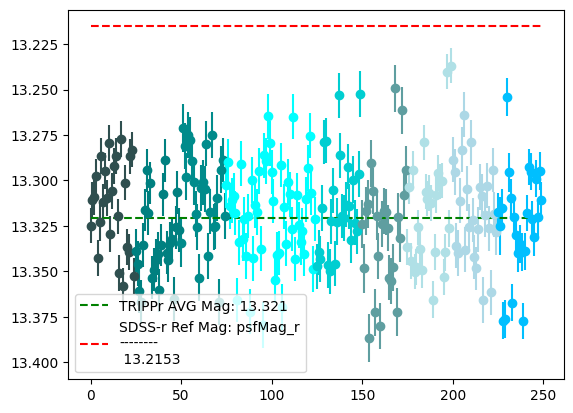

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.08497635, 54.39021174)>, rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.41951301050293, cal_mag_avg: 13.734013246312283, flagged: False, ID: 59
None


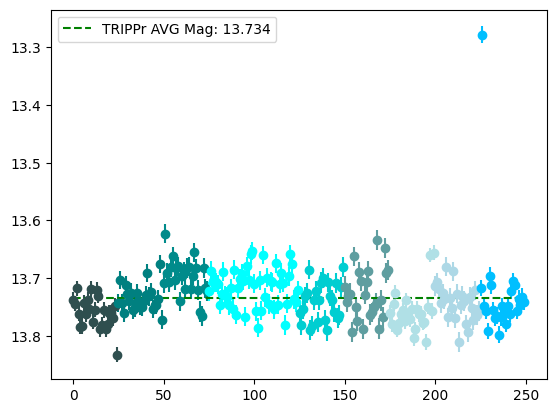

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.09030766, 54.32292807)>, rad: 10.5, ref_status: None, ref_mag: None, inst_mag_avg:-12.337999823125655, cal_mag_avg: 12.049413202648802, flagged: False, ID: 60
None


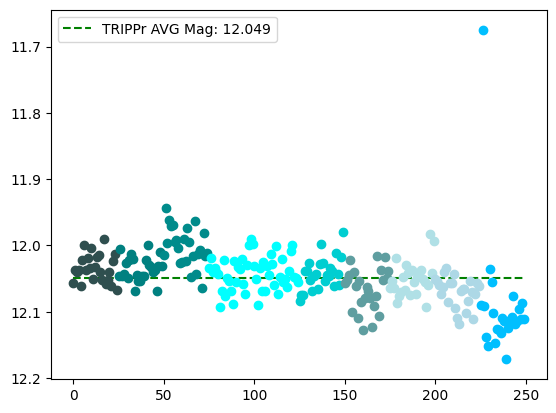

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12036051, 54.39700063)>, rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.187049230940406, cal_mag_avg: 14.814581247746998, flagged: False, ID: 61
None


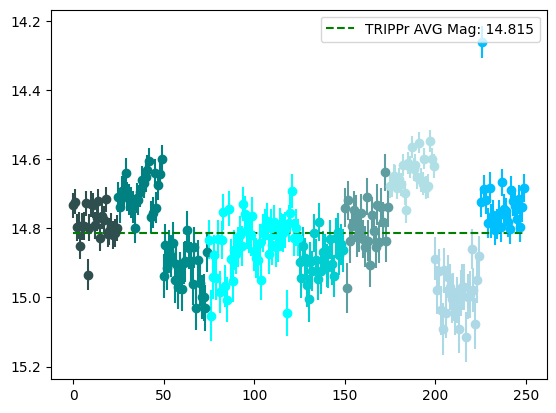

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12238072, 54.3964228)>, rad: 9.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.464190145758955, cal_mag_avg: 14.571432911050298, flagged: False, ID: 62
None


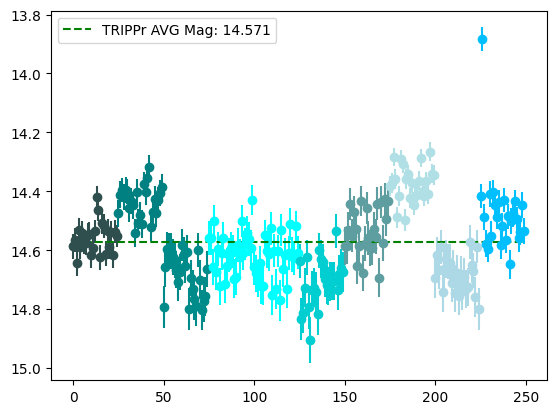

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12184327, 54.39801681)>, rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.052506283141044, cal_mag_avg: 15.810645240061747, flagged: False, ID: 63
None


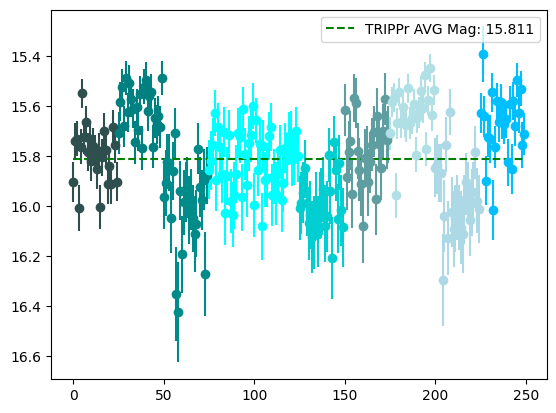

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12521481, 54.25972344)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.796854333126212, cal_mag_avg: 16.034413566737328, flagged: False, ID: 64
None


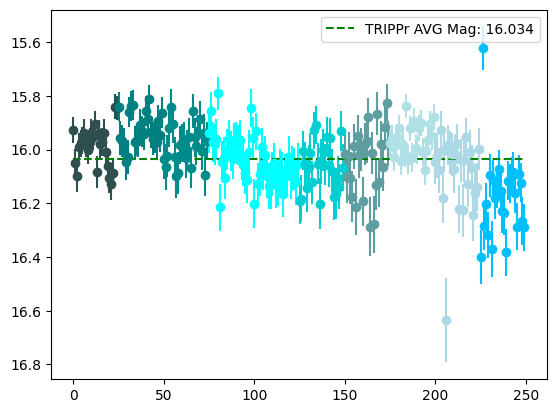

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12054456, 54.08428834)>, rad: 5.0, ref_status: True, ref_mag: psfMag_r
--------
14.16824, inst_mag_avg:-9.855648049911894, cal_mag_avg: 14.228712730138504, flagged: False, ID: 65
None
       psfMag_r      
---------------------
-0.060472730138503294


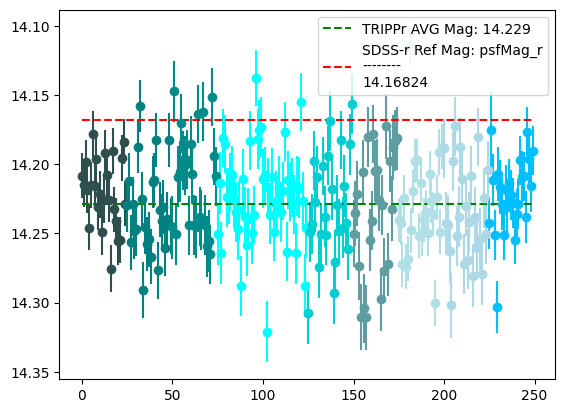

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.17529361, 54.35187118)>, rad: 9.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.99258051740659, cal_mag_avg: 12.352844891797886, flagged: False, ID: 66
None


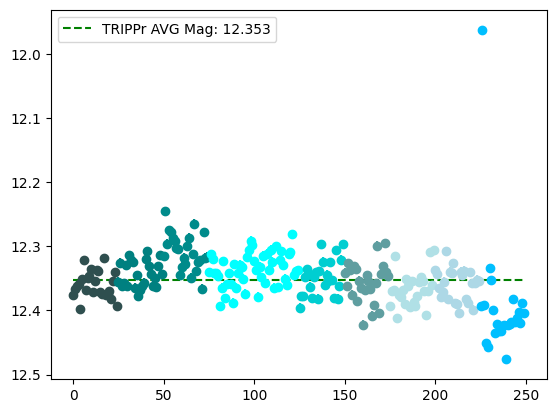

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.21211591, 54.19464639)>, rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
 15.9441, inst_mag_avg:-7.997240770389215, cal_mag_avg: 15.859265776000012, flagged: False, ID: 67
None
      psfMag_r     
-------------------
0.08483422399998908


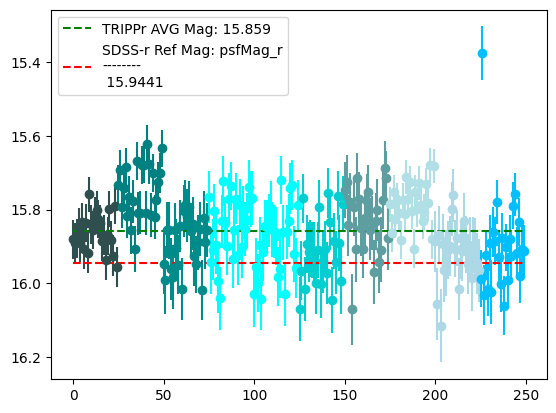

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.231828, 54.40298931)>, rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.048987847812514, cal_mag_avg: 15.81392397803391, flagged: False, ID: 68
None


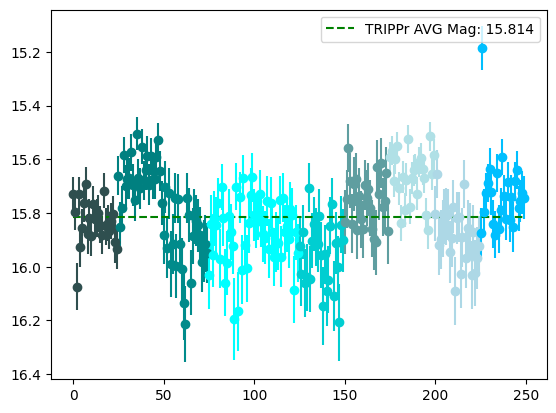

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.23332181, 54.22956903)>, rad: 2.5, ref_status: True, ref_mag: psfMag_r
--------
16.59565, inst_mag_avg:-7.201207695924277, cal_mag_avg: 16.55699381630013, flagged: False, ID: 69
None
      psfMag_r      
--------------------
0.038656183699870894


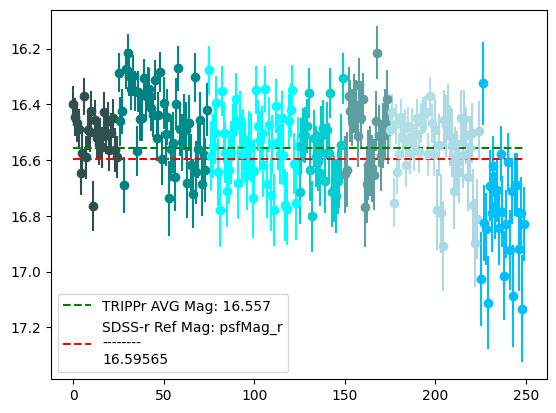

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.25972667, 54.33924396)>, rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
13.37774, inst_mag_avg:-10.716058568618232, cal_mag_avg: 13.473494798148357, flagged: False, ID: 70
None
      psfMag_r      
--------------------
-0.09575479814835752


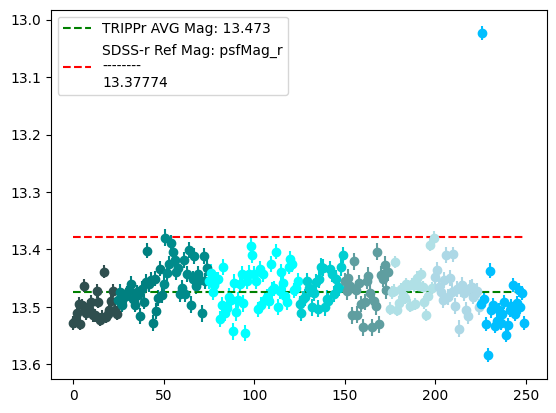

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.27877934, 54.05855765)>, rad: 21.0, ref_status: True, ref_mag: psfMag_r
--------
9.829223, inst_mag_avg:-14.468373919977756, cal_mag_avg: 10.17839928142574, flagged: False, ID: 71
None
      psfMag_r      
--------------------
-0.34917628142573953


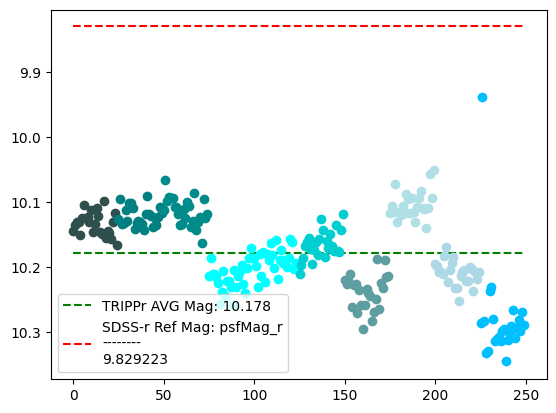

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30345384, 54.41397668)>, rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.35447, inst_mag_avg:-7.560554489868435, cal_mag_avg: 16.24272865804855, flagged: False, ID: 72
None
      psfMag_r     
-------------------
0.11174134195145058


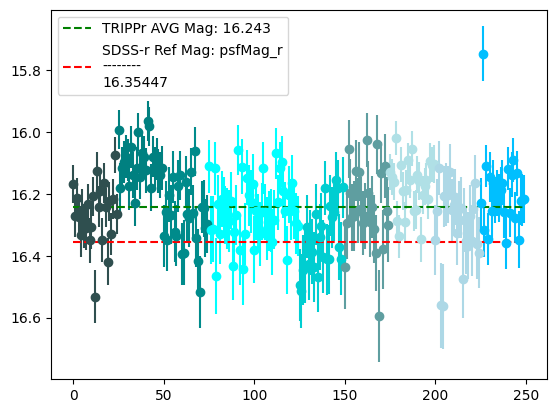

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.29844756, 54.26495767)>, rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.35837, inst_mag_avg:-7.569463830006737, cal_mag_avg: 16.234273828038337, flagged: False, ID: 73
None
      psfMag_r     
-------------------
0.12409617196166423


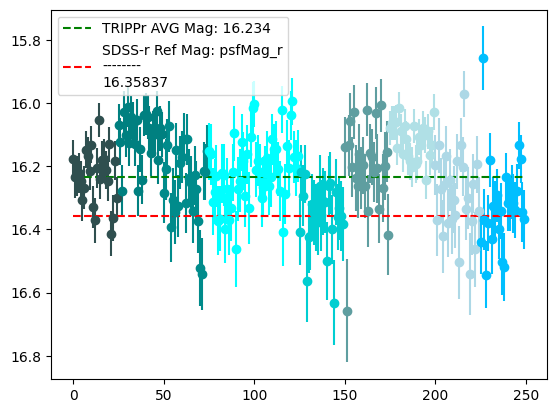

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30476211, 54.37648842)>, rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
16.30494, inst_mag_avg:-7.669969705031171, cal_mag_avg: 16.146775965881567, flagged: False, ID: 74
None
      psfMag_r     
-------------------
0.15816403411843183


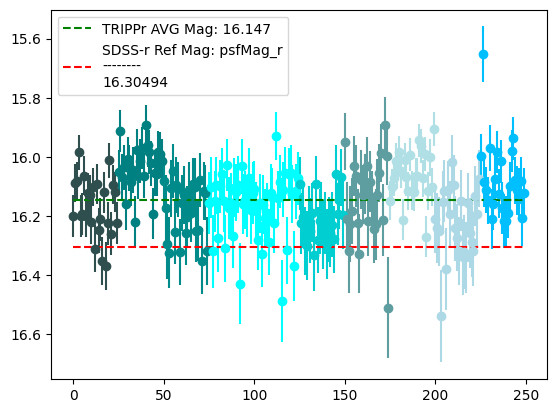

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30066365, 54.21154036)>, rad: 5.0, ref_status: True, ref_mag: psfMag_r
--------
14.42296, inst_mag_avg:-9.588028651726464, cal_mag_avg: 14.463702557849116, flagged: False, ID: 75
None
      psfMag_r      
--------------------
-0.04074255784911607


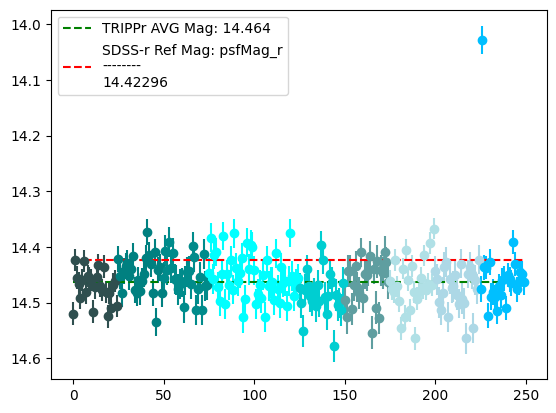

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.29289799, 53.99842441)>, rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
15.40109, inst_mag_avg:-8.471327258241374, cal_mag_avg: 15.443097790016038, flagged: False, ID: 76
None
      psfMag_r      
--------------------
-0.04200779001603827


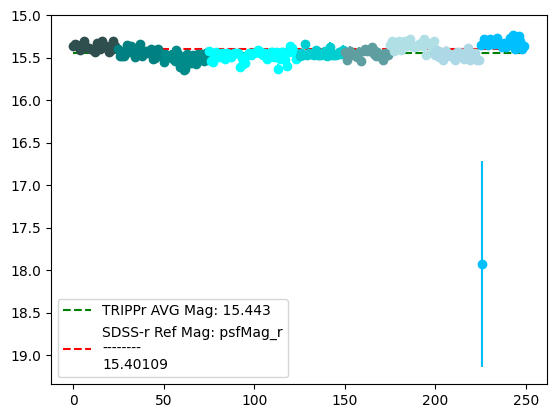

In [545]:

#print(color_arr[93::5][np.array(night_array)])
for source in Sources:
    if source.flagged != True:
        print(source.get_info())
        r = np.arange(0, len(source.calibrated_mags))

        for i, value in enumerate(source.calibrated_mags):
            plt.errorbar(i, value/med_curve[i], yerr=source.inst_mag_errs[i], linestyle = 'none', marker = 'o', c = color_arr[93::1][np.array(night_array)][i] )

        avg_mag =  np.mean(source.calibrated_mags)
        avg_mag_str = "%.3f" % avg_mag
        plt.plot(r, np.ones(len(r))*avg_mag, linestyle = '--', color = "g", label = f"TRIPP{Nights[0].obs_filter} AVG Mag: {avg_mag_str}")
        if source.is_reference:
            plt.plot(r, np.ones(len(r))*source.ref_mag, linestyle = '--', color = "r", label = f"SDSS-{Nights[0].obs_filter} Ref Mag: {source.ref_mag}")
            print(source.ref_mag-avg_mag)

        plt.gca().invert_yaxis()
        plt.legend()
        plt.show()


12 0 25 0


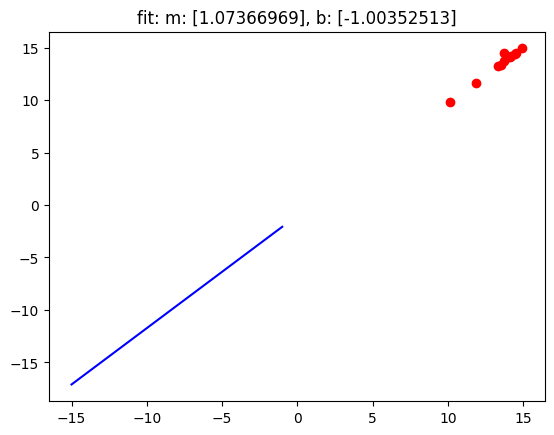

12 25 50 1


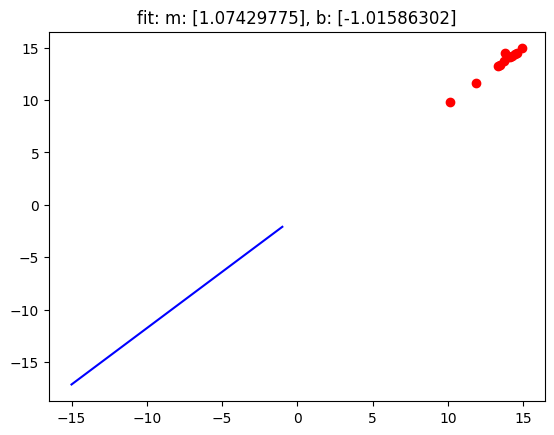

12 50 75 2


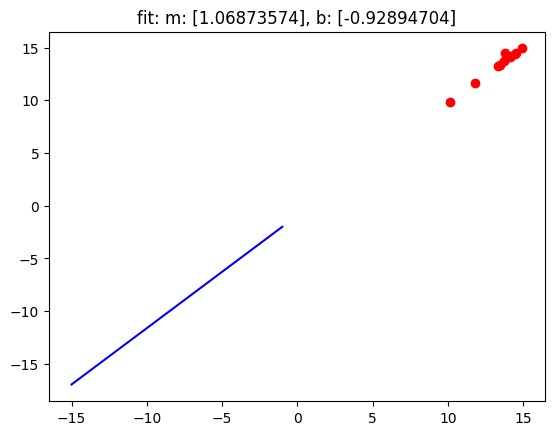

12 75 100 3


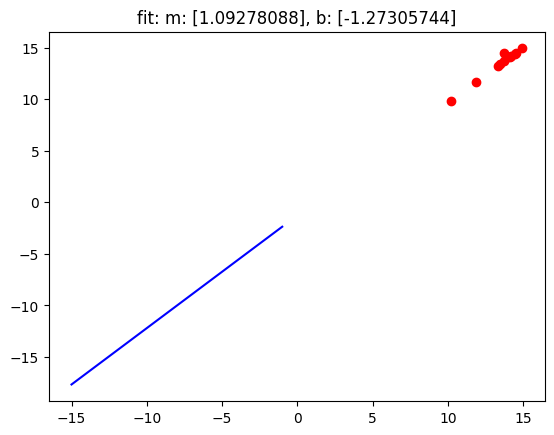

12 100 125 4


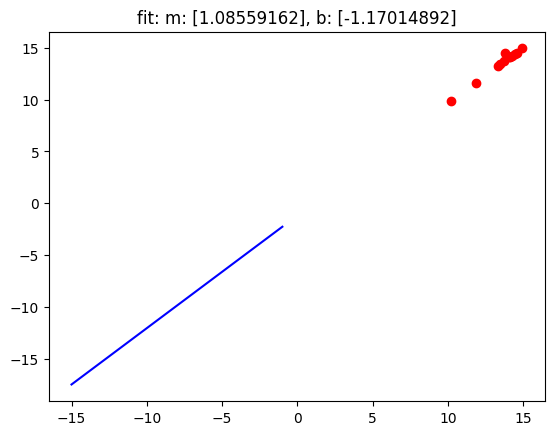

12 125 150 5


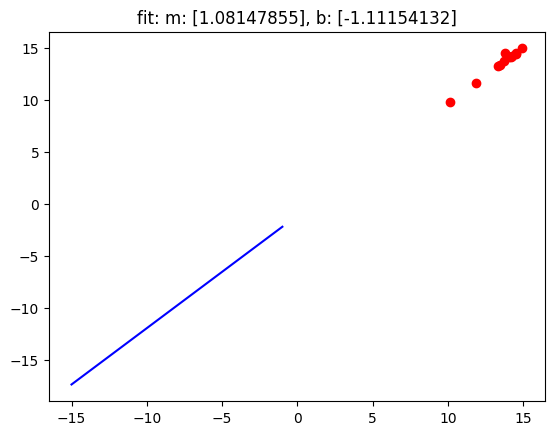

12 150 175 6


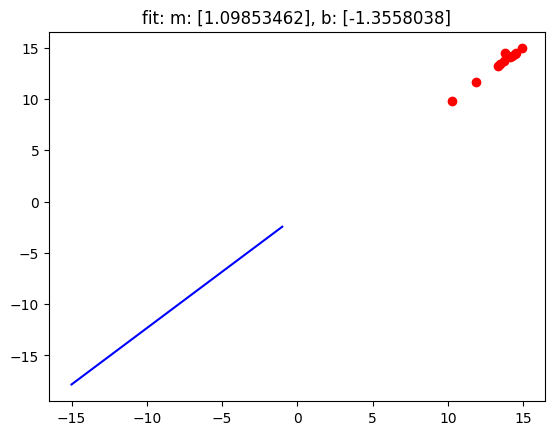

12 175 200 7


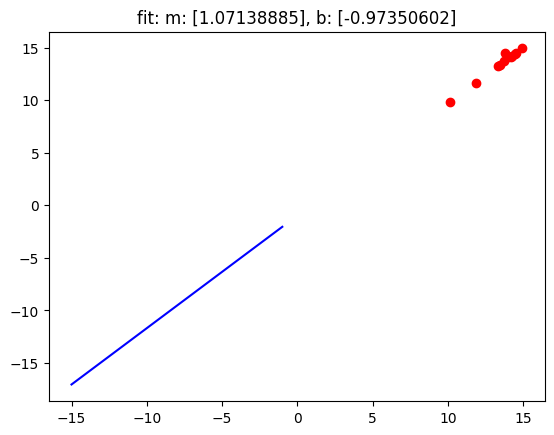

12 200 225 8


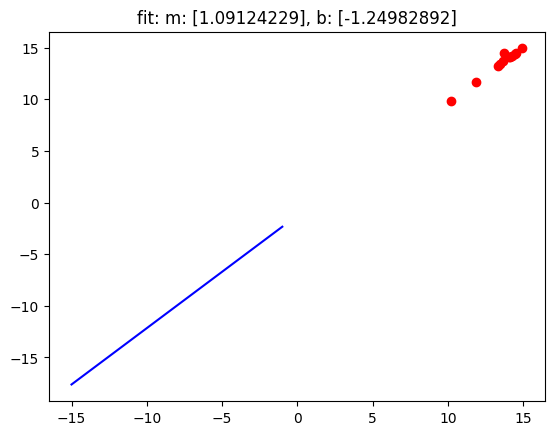

12 225 250 9


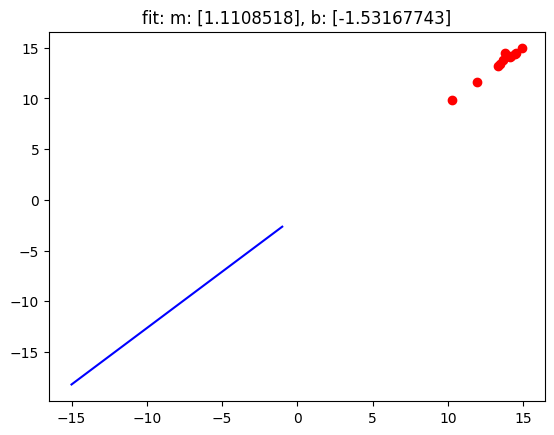

In [546]:
for night in Nights:
    index_low = len(night.image_data)*night.obs_night
    index_high = len(night.image_data)*(1+night.obs_night)
    x = [np.mean(source.calibrated_mags[index_low:index_high]) for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    y = [source.ref_mag for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
    print(len(x),  index_low, index_high, night.obs_night)
    p = np.polyfit(x, y, deg = 1)
    #r = np.arange(0, len(x))
    r = np.arange(-15, 0)
    plt.scatter(x, y, c = 'r')
    plt.plot(r, r*p[0] + p[1], c = 'b' )
    plt.title(f"fit: m: {p[0]}, b: {p[1]}")
    plt.show()

In [547]:
i = 0
for source in Sources:
    if source.is_reference == True:
        if source.ref_mag < 15:
            if source.flagged == False:
                i += 1

print(i)

12


In [548]:
for night in Nights:
    night.get_info()

path: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r, night 0, n_frames: 25, n_aligned: 25, wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.05004839  54.2290506116  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -3.53274375681e-06  0.000158524737521  
CD2_1 CD2_2  : -0.000158524737521  -3.53274375681e-06  
NAXIS : 3054  2042, n_ref: 81, filter: r
path: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r, night 1, n_frames: 25, n_aligned: 25, wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.032559917  54.2260533059  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -1.26304534592e-06  0.000158518530697  
CD2_1 CD2_2  : -0.000158518530697  -1.26304534592e-06  
NAXIS : 3054  2042, n_ref: 71, filter: r
path: /Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r, night 2, n_frames: 25, n_aligned: 25, wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DE

In [549]:
for source in Sources:
    source.get_info()

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.633724032747088, cal_mag_avg: 15.301093675504646, flagged: False, ID: 0
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.77550571, 54.14508597)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.709618408584095, cal_mag_avg: 16.111343111649482, flagged: False, ID: 1
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79248564, 54.39747745)>, rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.706171995415074, cal_mag_avg: 15.237726154964907, flagged: False, ID: 2
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80186801, 54.29859178)>, rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.037096617133915, cal_mag_avg: 16.702632335814485, flagged: False, ID: 3
ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79447654, 54.0838712)>, rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.381221642377652, cal_mag_avg: 14.

/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [550]:
print(calibration_parameters)

[ 0.97468419 24.11394542  0.97175198 23.88104041  0.94748647 23.5082359
  0.94283563 23.4773865   0.94949934 23.55866297  0.94865729 23.51765169
  0.93069684 23.29429     0.97956716 24.20423957  0.94153814 23.45588274
  0.94674625 23.73803081]


In [551]:
print(Sources[34].inst_mags)

[-13.131932780621465, -13.143116611129884, -13.133669477423549, -13.138180872106297, -13.143405518779009, -13.13436455192974, -13.138849070916116, -13.125139735864122, -13.139073677802955, -13.13451570046033, -13.137155725946233, -13.1417374371536, -13.138280442258381, -13.13929263789989, -13.141950959528192, -13.13724544828733, -13.152027888282234, -13.14873312993609, -13.145297549923246, -13.139308820459421, -13.142001286842795, -13.143339428758642, -13.133594337167603, -13.136547570743858, -13.147173535968593, -12.959940067455836, -12.9492615207121, -12.957364995377095, -12.957316753698882, -12.962078373825346, -12.962933668511862, -12.962593883820775, -12.969332130178215, -12.966059457869694, -12.974790593351129, -12.967462504380778, -12.971464027748713, -12.963505041069418, -12.977176638567924, -12.965806040735071, -12.969175947288615, -12.956614683806254, -12.954512359524879, -12.968539698411117, -12.962142534452967, -12.969840671988955, -12.957182620845028, -12.96802197326137, -

In [552]:
print(Sources[34].calibrated_mags)

[11.477070774160554, 11.466899035129803, 11.475491241402699, 11.471388109712436, 11.46663627245572, 11.474859068331176, 11.470780380195341, 11.483249075811663, 11.470576099324337, 11.474721598131955, 11.472320484286666, 11.468153399433179, 11.471297550256846, 11.470376954231561, 11.467959199970844, 11.472238881454953, 11.458794192557647, 11.461790788584485, 11.464915462486116, 11.47036223612829, 11.467913427074887, 11.46669638159625, 11.475559581769053, 11.47287360390021, 11.463209245598778, 11.452184501486197, 11.46184374068087, 11.454513773225974, 11.454557410054113, 11.450250304521923, 11.449476650938037, 11.449784001899236, 11.443688946562487, 11.446649229959881, 11.438751514280007, 11.445380109528324, 11.441760546653196, 11.448959818045402, 11.436593226075496, 11.44687845747352, 11.443830221206401, 11.455192464728405, 11.457094114230523, 11.444405737729632, 11.45019226826812, 11.443228946984986, 11.45467873942133, 11.444874044061805, 11.446318253981524, 11.45271915712333, 11.66154

In [553]:
for source in Sources:
    if source.is_reference:
        print(source.ref_mag, f"Id: {source.source_id}")

psfMag_r
--------
14.14103 Id: 13
psfMag_r
--------
16.39703 Id: 18
psfMag_r
--------
17.44732 Id: 19
psfMag_r
--------
14.09081 Id: 22
psfMag_r
--------
13.74609 Id: 23
psfMag_r
--------
14.91957 Id: 26
psfMag_r
--------
15.02432 Id: 30
psfMag_r
--------
16.40927 Id: 41
psfMag_r
--------
11.62752 Id: 43
psfMag_r
--------
15.32855 Id: 48
psfMag_r
--------
  14.504 Id: 49
psfMag_r
--------
14.47984 Id: 53
psfMag_r
--------
15.95399 Id: 55
psfMag_r
--------
 23.4499 Id: 56
psfMag_r
--------
 13.2153 Id: 58
psfMag_r
--------
14.16824 Id: 65
psfMag_r
--------
 15.9441 Id: 67
psfMag_r
--------
16.59565 Id: 69
psfMag_r
--------
13.37774 Id: 70
psfMag_r
--------
9.829223 Id: 71
psfMag_r
--------
16.35447 Id: 72
psfMag_r
--------
16.35837 Id: 73
psfMag_r
--------
16.30494 Id: 74
psfMag_r
--------
14.42296 Id: 75
psfMag_r
--------
15.40109 Id: 76
psfMag_r
--------
16.55701 Id: 77
psfMag_r
--------
16.61107 Id: 78
psfMag_r
--------
15.26117 Id: 79
psfMag_r
--------
13.82851 Id: 80
